In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os
import matplotlib.pyplot as plt

/home/jaehan/anaconda3/envs/darknet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)


사용하는 Device :  cuda


In [29]:

# train loader
os.getcwd()
transformer = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='/home/jaehan/DATASET_PCB/train/', transform = transformer)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = 10, shuffle = True, num_workers = 2)

print(trainset)

Dataset ImageFolder
    Number of datapoints: 158
    Root Location: /home/jaehan/DATASET_PCB/train/
    Transforms (if any): Compose(
                             Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


<class 'torch.Tensor'>
torch.Size([3, 132, 1042])


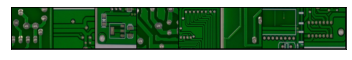

In [30]:
# sample check
sample, label = next(iter(train_loader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

In [31]:
# load wandb
import wandb
wandb.init()
wandb.run.name = 'CONVAE_2000'

In [32]:
#cuda init
import gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=3, featureDim=32*120*120, zDim=256):  #32 * (128-8 )*(128-8)iiji
        super(VAE, self).__init__()
        #encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5)
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)

        #decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)

    def encoder(self, x):
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*120*120) # 128-8
        mu = self.encFC1(x)  # 256
        logVar = self.encFC2(x)  # 256
        return mu, logVar

    def reparameterize(self, mu, logVar):

        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z):
        x = F.relu(self.decFC1(z)) #32 20 20
        x = x.view(-1, 32, 120, 120) # 128-8
        x = F.relu(self.decConv1(x)) # 32 16 5
        x = torch.sigmoid(self.decConv2(x)) # 16 3 5  
        return x  ##  1 deconv >> kernel +4 >> 2deconv Kernel +8

    def forward(self, x):
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar

In [34]:

batch_size = 10
learning_rate = 1e-3
num_epochs = 2000



net = VAE().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


total_steps = len(train_loader)
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):

        imgs, _ = data
        imgs = imgs.cuda()

        out, mu, logVar = net(imgs)
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        wandb.log({
            "Test Loss": loss/(total_steps*10),
            "kl_divergence": kl_divergence/total_steps})

    print('Epoch {}: Loss {}'.format(epoch, loss))

/home/jaehan/anaconda3/envs/darknet/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 184121.875
Epoch 1: Loss 171304.109375
Epoch 2: Loss 164583.4375
Epoch 3: Loss 160494.46875
Epoch 4: Loss 150504.890625
Epoch 5: Loss 169799.90625
Epoch 6: Loss 151708.515625
Epoch 7: Loss 159123.359375
Epoch 8: Loss 138376.390625
Epoch 9: Loss 145759.828125
Epoch 10: Loss 139763.375
Epoch 11: Loss 149846.515625
Epoch 12: Loss 142120.234375
Epoch 13: Loss 136465.546875
Epoch 14: Loss 150105.8125
Epoch 15: Loss 148687.609375
Epoch 16: Loss 139857.734375
Epoch 17: Loss 146404.796875
Epoch 18: Loss 146314.015625
Epoch 19: Loss 146581.515625
Epoch 20: Loss 141528.71875
Epoch 21: Loss 154579.734375
Epoch 22: Loss 137626.21875
Epoch 23: Loss 142004.578125
Epoch 24: Loss 134389.984375
Epoch 25: Loss 149368.140625
Epoch 26: Loss 149946.3125
Epoch 27: Loss 149871.5625
Epoch 28: Loss 149201.71875
Epoch 29: Loss 139238.96875
Epoch 30: Loss 143042.4375
Epoch 31: Loss 131927.359375
Epoch 32: Loss 148767.25
Epoch 33: Loss 145988.828125
Epoch 34: Loss 158842.75
Epoch 35: Loss 142429.906

In [35]:
#save model
# net --> model name
current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')
saved_loc = os.path.join('./weight', current_time)
os.mkdir(saved_loc)

print("저장 위치: ", saved_loc)
print(net)
PATH = saved_loc + '/' #'/home/jaehan/vae_pytorch_custom/caveweight/'

torch.save(net, PATH + 'model.pt')
torch.save(net.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  

저장 위치:  ./weight/2022-05-26-04:30
VAE(
  (encConv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (encConv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (encFC1): Linear(in_features=460800, out_features=256, bias=True)
  (encFC2): Linear(in_features=460800, out_features=256, bias=True)
  (decFC1): Linear(in_features=256, out_features=460800, bias=True)
  (decConv1): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (decConv2): ConvTranspose2d(16, 3, kernel_size=(5, 5), stride=(1, 1))
)


In [6]:
#load model
net = VAE().cuda()

batch_size = 1
learning_rate = 1e-3
num_epochs = 10
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

PATH = '/home/jaehan/Make_Conv_VAE/weight/2022-05-26-04:30/'
net = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
net.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
net.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [7]:
#test loader
os.getcwd()
transformer = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.ToTensor()])
testset = torchvision.datasets.ImageFolder(root='/home/jaehan/DATASET_PCB/test/crop', transform = transformer)

test_loader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)


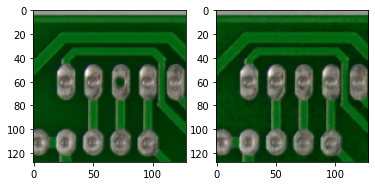

In [19]:
# make image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.cuda()
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))
        cv2.imwrite("img.jpg", img)
        cv2.imwrite("outimg.jpg", outimg)
        break

True

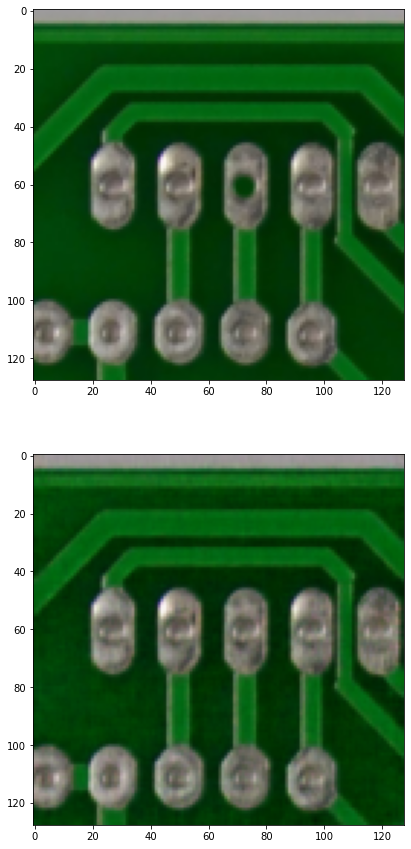

In [21]:

plt.rcParams["figure.figsize"] = (15, 15)

plt.subplot(211)
plt.imshow(img)

plt.subplot(212)
plt.imshow(outimg)
cv2.imwrite("img.jpg", img)
cv2.imwrite("outimg.jpg", outimg)

In [1]:
# subtract image
import cv2
# print(img)

cv2.imshow("a",outimg-img)
cv2.waitKey(0)
cv2.destroyAllWindows
# plt.rcParams["figure.figsize"] = (15, 15)


# plt.subplot(412)
# plt.imshow(outimg)



# plt.subplot(413)
# plt.imshow((outimg-img))
# a = outimg - img
# print(a.shape)


# threshold = 150
# plt.subplot(414)
# th_re = cv2.threshold(a, 0.5, maxval = 255, type = cv2.THRESH_BINARY)
# cv2.imshow("a",a)
# plt.imshow(th_re)


# plt.show()
# plt.subplot(311)

# plt.imshow(img[:,:,0], cmap='gray')
# plt.subplot(312)

# plt.imshow(outimg[:,:,0], cmap='gray')
# plt.subplot(313)

# plt.imshow((outimg-img)[:,:,0], cmap='gray')

# plt.imshow(img[:,:,2], cmap='gray')



NameError: name 'outimg' is not defined